In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import pytorch_lightning as pl
from model import *
from module import * 
import altair as alt
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import torch 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import argparse
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint
from  pytorch_lightning.loggers.tensorboard import TensorBoardLogger

Analyze distance prediction error

Analyze error per person

In [15]:
backbone = "resnet"
dataset = "comma"
bs = 1
gpu_num = 2

In [16]:
def mse_loss(input, target, mask, reduction="mean"):
        out = (input[~mask]-target[~mask])**2
        return out.mean() if reduction == "mean" else out 

In [96]:
def calculate_loss(logits, angle, distance, multitask):
        print(angle, distance, logits)
        if multitask == "multitask":
            logits_angle, logits_dist = logits
            mask = (distance > 50) | (distance == 0)
            loss_angle = torch.sqrt(mse_loss(logits_angle.squeeze(), angle.squeeze(), mask))
            loss_distance = torch.sqrt(mse_loss(logits_dist.squeeze(), distance.squeeze(), mask))
            loss = loss_angle, loss_distance
            
            return loss_angle, loss_distance
        elif multitask == "angle":
            mask = distance.squeeze() == 0.0 
            loss = torch.sqrt(mse_loss(logits.squeeze(), angle.squeeze(), mask))
            return loss
        elif multitask == "distance":
            mask = (distance > 50)  | (distance == 0)
            loss = torch.sqrt(mse_loss(logits.squeeze(), angle.squeeze(), mask))
            return loss

In [5]:
ckpt_pth_angle = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_angle/lightning_logs/version_17/checkpoints/epoch=21-step=1694.ckpt"
ckpt_pth_distance = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_40/checkpoints/epoch=39-step=1960.ckpt"
ckpt_pth_multitask = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt"

In [6]:
p = '/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_49/dist.csv'
df = pd.read_csv(p, header=None)

In [7]:
df.columns = ['preds', 'targets']


In [8]:
m = (df['targets'] > 40).astype(bool)  | (df['targets'] == 0).astype(bool) 
loss1 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))
m = (df['targets'] > 50).astype(bool)  | (df['targets'] == 0).astype(bool) 
loss2 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))
m = (df['targets'] > 60).astype(bool)  | (df['targets'] == 0).astype(bool) 
loss3 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))


In [9]:
loss1.item(), loss2.item(), loss3.item()

(3.520562596060591, 3.7951675788970936, 5.254393132189306)

Text(0, 0.5, 'RMSE')

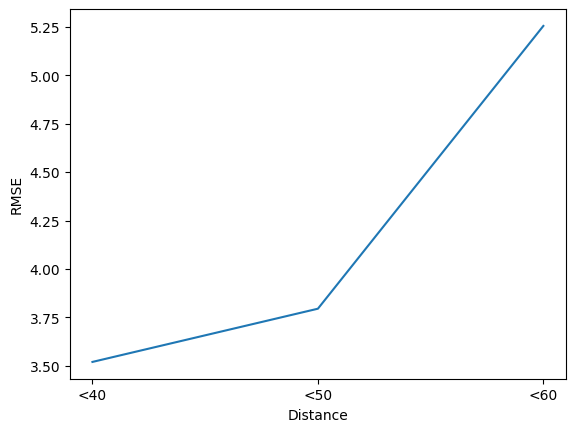

In [10]:
plt.plot(["<40", "<50", "<60"], [loss1.item(), loss2.item(), loss3.item()])
plt.xlabel("Distance")
plt.ylabel("RMSE")

In [12]:
res = {}

In [23]:

for ckpt_path in [ckpt_pth_distance, ckpt_pth_angle, ckpt_pth_multitask]:
    task = "angle" if 'angle' in ckpt_path else "distance" if "distance" in ckpt_path else "multitask"
    multitask = task == 'multitask'
    model = VTN(multitask=task, backbone=backbone)
    module = LaneModule(model, multitask=task, dataset = dataset, bs=bs, time_horizon=10)
    pth = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_{dataset}_{task}"
    logger = TensorBoardLogger(save_dir=pth)
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=[gpu_num] if torch.cuda.is_available() else None, 
        logger=logger,
        max_epochs=100,
        default_root_dir=pth
        )
    preds = trainer.predict(module, ckpt_path=ckpt_path)
    rmses = []
    for i in range(len(preds)):
        elem = preds[i]
        if multitask:
            logits_angle, logits_distance = elem[0][0], elem[0][1]
        logits, angle, distance = elem[0], elem[1].squeeze(), elem[2].squeeze()
        print(logits.shape, angle.shape, distance.shape)
        if "multitask" in ckpt_path:
            loss = calculate_loss(logits, angle, distance, multitask='multitask')  
            rmses.append(loss)
        if "angle" in ckpt_path:
            loss = calculate_loss(logits, angle, distance, multitask="angle") 
            rmses.append(loss.item())
        if "distance" in ckpt_path:
            distance = angle
            loss = calculate_loss(logits, distance, distance, multitask="distance")
            rmses.append(loss.item())
        
    res[task] = rmses
    print(rmses)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_40/checkpoints/epoch=39-step=1960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_40/checkpoints/epoch=39-step=1960.ckpt
/home/jessica/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 17/17 [04:02<00:00, 14.26s/it]
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
[1.630279

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_angle/lightning_logs/version_17/checkpoints/epoch=21-step=1694.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_angle/lightning_logs/version_17/checkpoints/epoch=21-step=1694.ckpt


Predicting DataLoader 0: 100%|██████████| 17/17 [04:06<00:00, 14.49s/it]
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
torch.Size([230]) torch.Size([230]) torch.Size([230])
[0.379748

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt


Predicting DataLoader 0:   0%|          | 0/17 [00:00<?, ?it/s]

AttributeError: 'VTN' object has no attribute 'multitask_param_angle'

In [24]:
df = pd.DataFrame()
df['distance'] = res['distance']
df['angle'] = res['angle']
df['driver'] = range(len(res['angle']))
alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X('distance',scale=alt.Scale(domain=(0, 16))),
    y=alt.Y('angle',scale=alt.Scale(domain=(0, 3))),
    tooltip=['driver']
).interactive()


alt.Chart(...)

In [ ]:
l = list(zip(*res["multitask"]))
z = l[1]
y = l[0]
df = pd.DataFrame()
df['distance'] = z
df['distance'] = df['distance'].apply(lambda x: x.item())
df['angle'] = y
df['angle'] = df['angle'].apply(lambda x: x.item())
df['driver'] = range(len(y))
alt.Chart(df).mark_circle(size=60).encode(
    x='distance',
    y='angle',
    tooltip=['driver']
).interactive()

In [ ]:
preds_path = '/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_49/dist.csv'
df = pd.read_csv(preds_path)
df.columns = ['preds', 'targets']
df = df[df['targets'] != 0]
df['err'] = df['targets'] - df['preds']
ten = df[df['targets'] < 10]
six = df[df['targets'] > 60]
twen = df[(df['targets'] > 10 & (df['targets'] < 20))]
four = df[(df['targets'] > 20 & (df['targets'] < 40))]
fift = df[(df['targets'] > 40 & (df['targets'] < 60))]
ndf = {}
ndf["<10"] = ten['err'].tolist()
ndf["10-20"] = twen['err'].tolist()
ndf["20-40"] = four['err'].tolist()
ndf["40-60"] = fift['err'].tolist()
ndf[">60"] = six['err'].tolist()
my_dict = ndf

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

In [21]:
multitask_parameter_resnet_backbone = '/data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_9/checkpoints/epoch=86-step=2523.ckpt'
multitask_parameter_vit_backbone = '/data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_22/checkpoints/epoch=9-step=2280.ckpt'
angle_vit_backbone =  '/data1/jessica/data/toyota/ckpts/checkpoints_comma_angle/lightning_logs/version_2/checkpoints/epoch=11-step=2736.ckpt'
distance_vit_backbone =  '/data1/jessica/data/toyota/ckpts/checkpoints_comma_distance/lightning_logs/version_0/checkpoints/epoch=25-step=5928.ckpt'
multitask_resnet_backbone_03_07_angle_dist = '/data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=64-step=3705.ckpt'
multitask_resnet_backbone_7_3_angle_dist = '/data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_24/checkpoints/epoch=48-step=11172.ckp'

In [73]:
res_dict = {}

In [94]:

backbone = "resnet"
dataset = "comma"
bs = 1
gpu_num = 2
for ckpt_path in [multitask_parameter_resnet_backbone]:#distance_vit_backbone, angle_vit_backbone, multitask_parameter_vit_backbone]:
    task = "angle" if 'angle' in ckpt_path else "distance" if "distance" in ckpt_path else "multitask"
    model = VTN(multitask=task, backbone=backbone)
    module = LaneModule(model, multitask=task, dataset = dataset, bs=bs)
    pth = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_{dataset}_{task}"
    logger = TensorBoardLogger(save_dir=pth)
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=[gpu_num] if torch.cuda.is_available() else None, 
        logger=logger,
        max_epochs=100,
        default_root_dir=pth
        )
    preds = trainer.predict(module, ckpt_path=ckpt_path)
    res_dict[ckpt_path] = preds


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_9/checkpoints/epoch=86-step=2523.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_9/checkpoints/epoch=86-step=2523.ckpt
/home/jessica/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]


In [97]:
for key in res_dict.keys():
    preds = res_dict[key]
    logits_angle = []
    logits = []
    logits_dist = []
    angle = []
    dist = []
    for elem in preds: 
        angle.extend(elem[1].squeeze().tolist())
        dist.extend(elem[2].squeeze().tolist())
        if "multitask" not in key:
            logits.extend(elem[0].squeeze().tolist())
        else:
            logits_angle.extend(elem[0][0].squeeze().tolist())
            logits_dist.extend(elem[0][1].squeeze().tolist())
    
    print(key, calculate_loss(torch.tensor(logits) if "multitask" not in key else (torch.tensor(logits_angle), torch.tensor(logits_dist)), torch.tensor(angle), torch.tensor(dist), "distance" if 'dist' in key else ("angle" if "angle" in key else "multitask")))

/data1/jessica/data/toyota/ckpts/checkpoints_comma_distance/lightning_logs/version_0/checkpoints/epoch=25-step=5928.ckpt tensor(12.2290)
/data1/jessica/data/toyota/ckpts/checkpoints_comma_angle/lightning_logs/version_2/checkpoints/epoch=11-step=2736.ckpt tensor(5.4740)
tensor([-1.9000, -1.9000, -1.6000,  ...,  6.0000,  8.0000,  8.2000]) tensor([61.5600, 61.3200, 61.5800,  ..., 22.2000, 22.6200, 22.9200])
/data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_22/checkpoints/epoch=9-step=2280.ckpt (tensor(9.1058), tensor(5.2456))
tensor([-1.9000, -1.9000, -1.6000,  ...,  6.0000,  8.0000,  8.2000]) tensor([61.5600, 61.3200, 61.5800,  ..., 22.2000, 22.6200, 22.9200])
/data1/jessica/data/toyota/ckpts/checkpoints_comma_multitask/lightning_logs/version_9/checkpoints/epoch=86-step=2523.ckpt (tensor(7.0857), tensor(3.1160))


tensor(2.2802)